# Profiling Dask read performance

Let's take a look at the impact of threads vs processes on read speeds, using the 'strace' profile.

'strace' is a command on linux that records system calls from the program to the operating system. System calls are how your program interacts with the filesystem, and include commands like `open()`, `read()`, `write()`, and `close()` along with many more.

'strace' runs by wrapping around another program, just like 'time' does:

```shell
strace python mean.py
```

and outputs a list of all the system calls made to stderr:

```
2809601 1632284156.604957523 openat(AT_FDCWD, "/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100101-20100131.nc", O_RDONLY|O_CLOEXEC) = 55 <0.000377>
2809601 1632284156.605830189 fstat(55, {st_mode=S_IFREG|0660, st_size=969135808, ...}) = 0 <0.000069>
2809601 1632284156.606097458 ioctl(55, TCGETS, 0x7ffdb53870f0) = -1 ENOTTY (Inappropriate ioctl for device) <0.000014>
2809601 1632284156.606929038 lseek(55, 0, SEEK_CUR) = 0 <0.000021>
2809601 1632284156.607167790 lseek(55, 0, SEEK_CUR) = 0 <0.000019>
```

in this way we can see when all of the file reads are happening, which rank (either process or thread) is doing the read, and how fast that read is.

## Filtering and looking at strace output

The base output of strace is overwhelming, and makes it hard to find the relevant system calls we're interested in. It does however provide a good range of options for filtering the output so that it's easier to see what's happening.

```bash
strace
    --output trace # save the trace to a file, rather than stderr
    --follow-forks # trace any forks (i.e. processes and/or threads) created by the program as well
    -P '/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100101-20100131.nc' # Only look at reads to these files
    -P '/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100201-20100228.nc'
    --timestamps=format:unix,precision:ns # Record the time each system call was run at, in seconds
    --syscall-times # Record how long the operating system took to run the system call
    python mean.py
```

In the output, the majority of lines look something like
```
3637846 1632202048.147773948 pread64(8, "x^\0\5@\372\277\375!izT=\22\345\2655\314c\356b\206\3\265\225L\2\335\363\4\240g"..., 2201358, 450207942) = 2201358 <0.000587>
```

The values are in order the process id doing the call, the time the call was run (in seconds since Jan 1 1970), the call and its arguments, the return value of the call, then in the angle brackets is the time taken to run the call in seconds.

You can check what the arguments of the command are in its manpage, e.g. by running `man pread64`. This tells us that the arguments are 'file descriptor', 'buffer', 'number of bytes to read', 'offset in file', and the return value is the number of bytes that were read.

```
SYNOPSIS
        ssize_t pread(int fd, void *buf, size_t count, off_t offset);

DESCRIPTION
       pread() reads up to count bytes from file descriptor fd at offset offset (from the start of the file) into the buffer starting at buf.  The file offset is not changed.

       The file referenced by fd must be capable of seeking.

RETURN VALUE
       On success, pread() returns the number of bytes read (a return of zero indicates end of file)
```

So the strace line means that at timestamp 1632202048 the process with id 3637846 ran the `pread64` call, asking to read 2201358 bytes from file id 8. The full 2201358 bytes were read, and the read took 0.000587 seconds.

### Threads and Processes in strace output

In the strace output threads and processes work the same way, separate threads/processes always have different process ids (the first number in the output). I'll generally refer to both threads and processes interchangably as 'ranks'.

## A program to profile

I'll start with a simple program, that just calculates the global mean of two months of era5 data.

```python
files = ['/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100101-20100131.nc', '/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100201-20100228.nc']

das = []
for f in files:
    da = xarray.open_dataset(f)['t2m']
    chunks = dict(zip(da.dims, da.encoding['chunksizes']))
    chunks['time'] = -1
    da = da.chunk(chunks)
    das.append(da)

ds = xarray.concat(das, dim='time')
print(ds.mean().load())
```

Rather than using `xarray.open_mfdataset` I've opened each file separately so the results are clearer to see. The NCI ERA5 files don't all have the same internal chunking, so if you use `open_mfdataset` to give all the same chunks you're not always reading one file chunk with one dask chunk.

I've run this program on Gadi's compute node with 4 CPUs, both using Dask's default thread scheduler and a `dask.distributed.Client()` with 4 processors.

In [1]:
import pandas
import re
import matplotlib.pyplot as plt
import dask
import numpy
from matplotlib import cm

## Reading strace output in Python

This function reads the output from strace and creates a Pandas DataFrame with the results.

There are a couple extra complexities we need to deal with here. When running in parallel it's possible for two or more ranks to be using a system call at the same time. In this case the output will have a line ending with `<unfinished ...>` marking the start time when another rank runs a system call while this call is still running, then once the original call has finished it will get a line with `<... resumed>` marking the result and call duration.

While threads and processes for the most part work the same in the strace output, there is one annoying difference. With threads, each rank's file ids will be copied from the parent process. So if the parent process opens file '2t_era5_oper_sfc_20100101-20100131.nc' as file id 8, then all of the threads will be using that same file id to read from that file. Processes on the other hand each open the file separately, so process 1 might open the file as file id 8, process 2 as file id 45 and so on.

When looking at the profile results it's nice to be able to see when the same file is being read by different ranks. At the end of the function is some cleanup to match up the file ids across all the different ranks.

In [2]:
re_signal = re.compile(r'(?P<proc>[0-9]+) (?P<timestamp>[0-9.]+) (\+\+\+|\-\-\-).*')
re_call = re.compile(r'(?P<proc>[0-9]+) (?P<timestamp>[0-9.]+) (?P<call>[A-Za-z0-9_]+)\((?P<args>.*)\)\s*= (?P<ret>-?[0-9]+) (?P<errcode>.*)?<(?P<cost>[0-9.]+)>')
re_call_start = re.compile(r'(?P<proc>[0-9]+) (?P<timestamp>[0-9.]+) (?P<call>[A-Za-z0-9_]+)\((?P<args>.*) <unfinished ...>')
re_call_end = re.compile(r'(?P<proc>[0-9]+) (?P<timestamp>[0-9.]+) <... (?P<call>[A-Za-z0-9_]+) resumed>(?P<args>.*)\)\s*= (?P<ret>-?[0-9]+) (?P<errcode>.*)?<(?P<cost>[0-9.]+)>')

def read_trace(filename):
    state = {}
    result = []
    
    with open(filename) as f:
        for line in f:
            # A signal - ignore
            match = re_signal.match(line)
            if match is not None:
                continue
                
            # A system call that is unfinished - save the important info to the 'state' dict
            match = re_call_start.match(line)
            if match is not None:
                state[match['proc']] = {'timestamp': match['timestamp'], 'call': match['call'], 'args': match['args']}
                continue
                
            # End of an unfinished call - get the start time from the 'state' dict and add to 'result'
            match = re_call_end.match(line)
            if match is not None:
                s = state[match['proc']]
                args = s['args'] + match['args']
                
                try:
                    file = int(args.split(', ')[0])
                except:
                    file = None
                
                result.append([int(match['proc']),float(s['timestamp']),match['call'], float(match['cost']), int(match['ret']), file, args])
                continue
                
            # A normal call - add the result to the 'result' array
            match = re_call.match(line)
            if match is not None:
                args = match['args']
                try:
                    file = int(args.split(', ')[0])
                except:
                    file = None
                    
                result.append([int(match['proc']),float(match['timestamp']),match['call'], float(match['cost']), int(match['ret']), file, args])
                continue
            
            # Print out any unmatched lines
            print(line)
            
    # Convert to a dataframe
    df = pandas.DataFrame(result, columns=['proc','time','call','cost', 'ret', 'file', 'args'])
    
    # Work out what files were opened
    fnames = {v:k for k,v in enumerate(df[df.call == 'openat'].args.unique())}

    # Mapping from the FILE values on each processor to consistent file ids
    proc_file_ids = {}
    for proc, dd in df[df.call == 'openat'].groupby('proc'):
        proc_file_ids[proc] = dict(dd.apply(lambda r: (r.ret, fnames[r.args]), axis=1).values)
        
    df['file_id'] = df.apply(lambda r: proc_file_ids.get(r.proc,list(proc_file_ids.values())[0]).get(r.file, None), axis=1)
    
    return df.set_index('time')

## File read timelines

As a starting point let's make a timeline plot, where the x axis is time and the y axis is different ranks, showing what each rank is doing as the program runs.

I'll show only read calls, when there is a box present then a file read is happening. Box colour indicates what file is being read.

In [3]:
def plot_timeline(trace):
    df = read_trace(trace)
    
    # Set the time origin to the start of the program
    t0 = df.index[0]
    df.index = df.index - t0

    # Convert the process ids to consecutive numbers for the y axis
    proc_map = {v:k for k, v in enumerate(df.proc.unique())}
    df['proc_id'] =  df.proc.apply(lambda x: proc_map[x])
    
    # Filter to only the read calls
    d = df[df.call == 'pread64']

    # Setup colours
    cmap = cm.get_cmap('plasma', 5)
    norm = plt.Normalize(df.file_id.min(), df.file_id.max())

    # Make a 'broken_barh' plot for each rank
    plt.figure(figsize=(20,10))
    for proc, dd in d.groupby('proc_id'):
        xranges = [(k, r.cost) for k, r in dd.iterrows()]
        colors = cmap(norm(dd.file_id))

        plt.broken_barh(xranges, [proc,1], color=colors)

### Four Threads

Looking at the file access when the default thread scheduler is being used you can clearly see a diagonal pattern. Each thread gets its turn to read from a file for around 0.2 seconds, then the next thread gets its turn.

Only one thread at a time can read from a netCDF file, regardless of what file it is. You never see the blue and yellow files being read at the same time.

This may or may not be a problem - if you've got a simple computation then the other threads are doing nothing while one thread is reading from a file, but for more complex tasks then the other threads will be doing work while waiting for their turn to read.

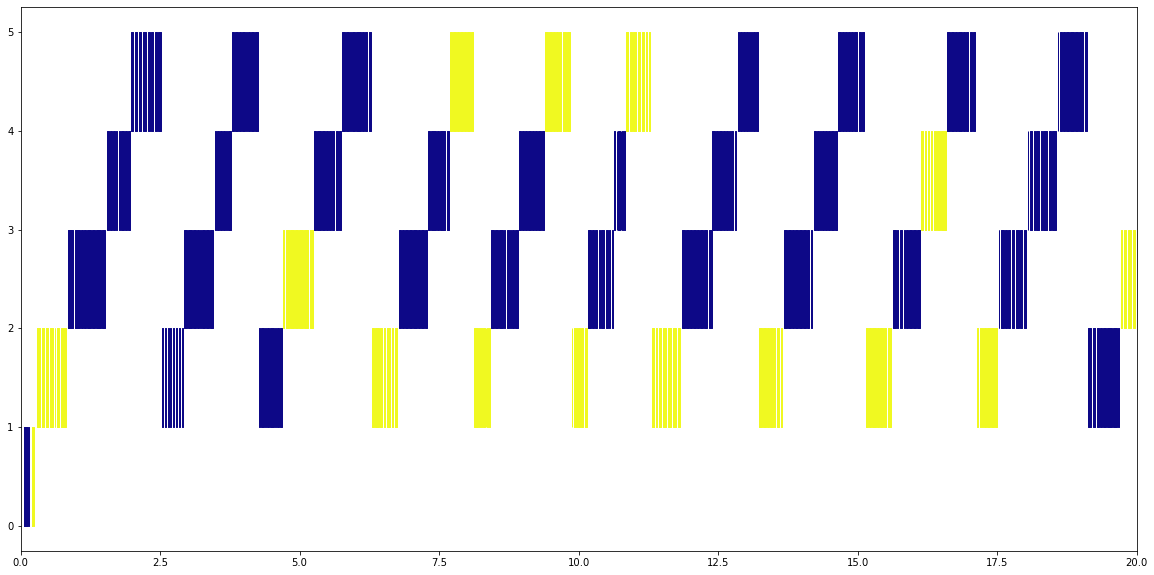

In [4]:
plot_timeline('trace.2files.4procs')
plt.xlim(0,20);

### Four Processes

Processes on the other hand is much more mixed up. Different processes can read at the same time, whether or not the read is from the same file. We're only looking at the first 20 seconds of the run here, but the total run ends up taking about 25 seconds rather than nearly 60 seconds for the threaded read.

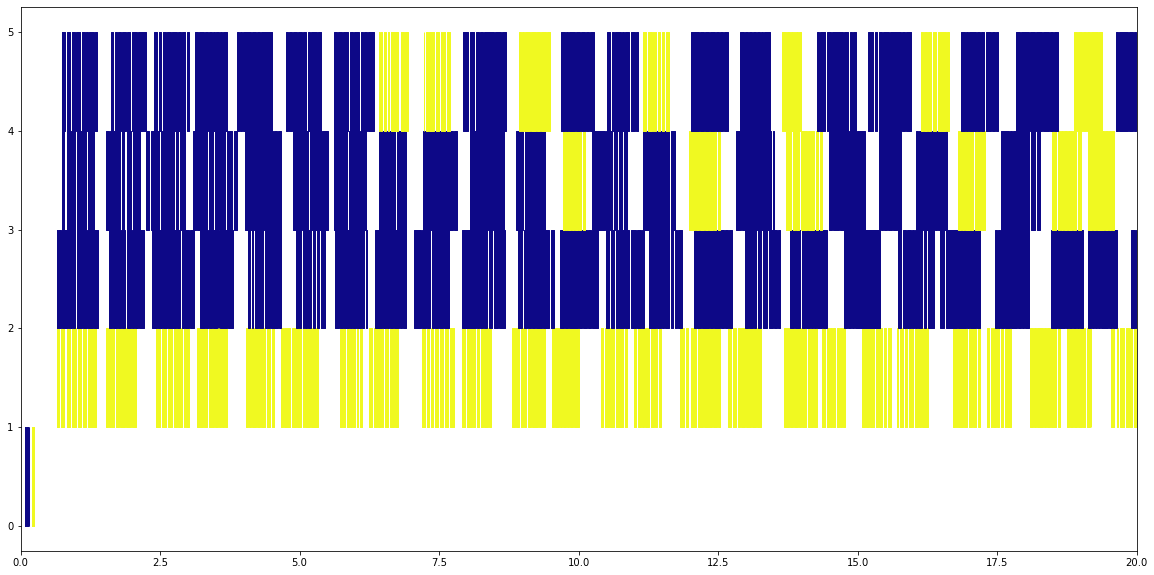

In [5]:
plot_timeline('trace_dist.2files.4procs')
plt.xlim(0,20);

## Read speed and caching

Let's take a look at how fast the disk is performing, by plotting the IO speed of each read. The plot is now showing read speed in bytes per second on the y axis, with the values coloured by rank.

For the test with processes, the speed is fairly consistent, with a mean speed of about 50 MB/second

In [6]:
def plot_readspeed_by_process(trace, max):
    df = read_trace(trace)
    
    t0 = df.index[0]
    df.index = df.index - t0
    
    d = df[df.call == 'pread64']

    proc_map = {v:k for k, v in enumerate(d.proc.unique())}
    proc = d.proc.apply(lambda x: proc_map[x])

    cmap = cm.get_cmap('viridis', 64)
    colors = cmap(plt.Normalize(proc.min(), proc.max())(proc))

    plt.figure(figsize=(20,10))
    plt.bar(d.index, d.ret / d.cost, 0.05, color=colors)
    d.cost.plot(linestyle='none', marker='.')
    plt.ylabel('read speed')
    plt.xlabel('runtime (s)')
    
    ticks = numpy.linspace(0,max,6)
    plt.yticks([dask.utils.parse_bytes(f'{t} MB') for t in ticks], [f'{t} MB/s' for t in ticks])
    loc,label = plt.yticks()
    plt.ylim(loc[0], loc[-1])
    
    print(f"Mean speed {dask.utils.format_bytes((d.ret/d.cost).mean())}/s")

Mean speed 51.76 MiB/s


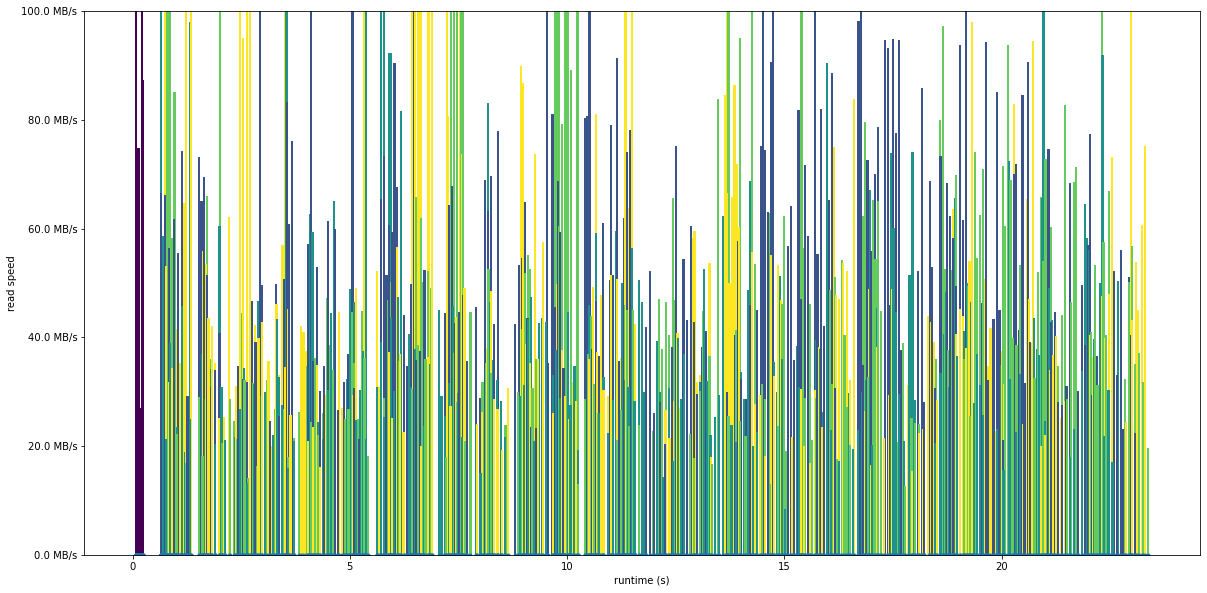

In [7]:
plot_readspeed_by_process('trace_dist.2files.4procs', 100)

Below is a second run, that starts off the same as the previous run but then the read speed jumps massively, with a mean read speed of 1.65 GB/s. It's reading exactly the same data, all that's happened is the value is calculated again a second time after the first calculation is complete.

```python
files = ['/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100101-20100131.nc', '/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100201-20100228.nc']

das = []
for f in files:
    da = xarray.open_dataset(f)['t2m']
    chunks = dict(zip(da.dims, da.encoding['chunksizes']))
    chunks['time'] = -1
    da = da.chunk(chunks)
    das.append(da)

ds = xarray.concat(das, dim='time')
print(ds.mean().load())
print(ds.mean().load())
```

This shows the massive effect that caching can have on IO performance. If you re-read data that you've recently read from a file, it's going to be much faster the second time round. The operating system keeps data that was recently read in a in-memory cache so that it doesn't need to go back to the hard disk, which is much slower.

Mean speed 1.65 GiB/s


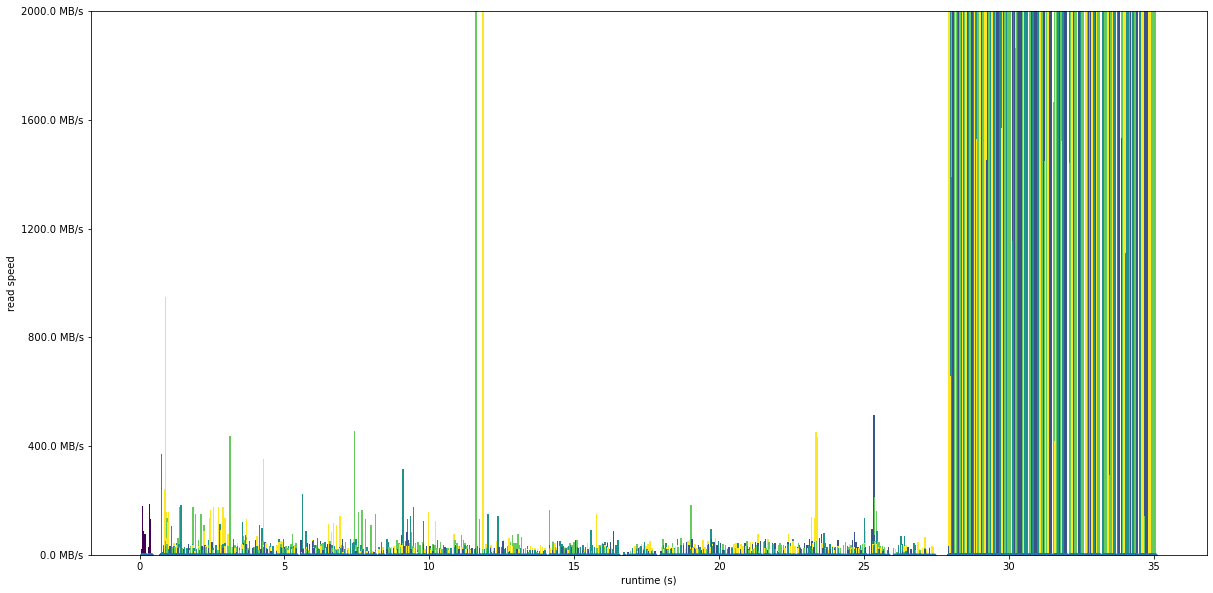

In [8]:
plot_readspeed_by_process('trace_dist_x2.2files.4procs', 2000)

This is also why I didn't use open_mfdataset for this demonstration- if the chunks for all files don't line up with the dask chuning then some data gets read from cache, messing up profile measurements

```python
files = ['/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100101-20100131.nc', '/g/data/rt52/era5/single-levels/reanalysis/2t/2010/2t_era5_oper_sfc_20100201-20100228.nc']

ds = xarray.open_mfdataset(files, chunks={'time': -1, 'lat': 91, 'lon': 180})

print(ds.mean().load())
```

Mean speed 1.88 GiB/s


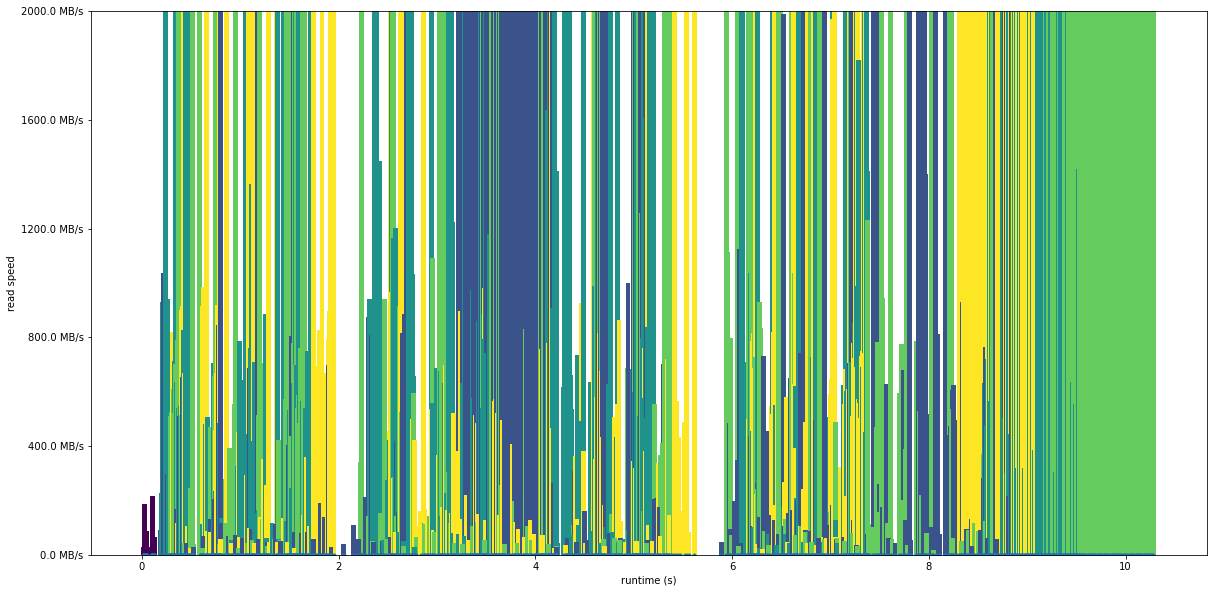

In [9]:
plot_readspeed_by_process('trace_dist_mf.2files.4procs', 2000)

## Conclusions

* In general, prefer using processes (i.e. dask.distributed.Client) to threads when reading NetCDF files with xarray+dask
* Be careful of the effects of disk caching when profiling - reading data a second time is much faster than the first time it's read
* The strace tool can give useful insights into how IO is happening within a program